In [1]:
from Simulator import Simulator
from Timer import Timer

with Timer("build_simulator") :
    neuron_network_filename = "Network2"
    simulator = Simulator(neuron_network_filename)
    
with Timer("make_graph_board") :
    simulator.graph.make_graph_board(0)

simulator.boarn()

======================== build_simulator ==========================

Elapsed time : 0.00000000 sec 
======================== make_graph_board ==========================

Elapsed time : 0.03125000 sec 


In [ ]:
debug_config = {"debug_mode":"true"}
simulator.graph.debug_set(debug_config)

In [ ]:
debug_config = {"debug_include":["Inner"]}
simulator.graph.debug_set(debug_config)

In [ ]:
debug_config = {"debug_remove":["Inner/G0/b#0/Ca+"]}
simulator.graph.debug_set(debug_config)

In [2]:
with Timer("one_step_CPU") :
    for i in range(10000) :
        simulator.one_step()

======================== one_step_CPU ==========================
 test
{'age': 0}
{}
test
{'age': 1}
{}
test
{'age': 2}
{}
test
{'age': 3}
{}
test
{'age': 4}
{}
test
{'age': 5}
{}
test
{'age': 6}
{}
test
{'age': 7}
{}
test
{'age': 8}
{}
test
{'age': 9}
{}
test
{'age': 10}
{}
test
{'age': 11}
{}
test
{'age': 12}
{}
test
{'age': 13}
{}
test
{'age': 14}
{}
test
{'age': 15}
{}
test
{'age': 16}
{}
test
{'age': 17}
{}
test
{'age': 18}
{}
test
{'age': 19}
{}
test
{'age': 20}
{}
test
{'age': 21}
{}
test
{'age': 22}
{}
test
{'age': 23}
{}
test
{'age': 24}
{}
test
{'age': 25}
{}
test
{'age': 26}
{}
test
{'age': 27}
{}
test
{'age': 28}
{}
test
{'age': 29}
{}
test
{'age': 30}
{}
test
{'age': 31}
{}
test
{'age': 32}
{}
test
{'age': 33}
{}
test
{'age': 34}
{}
test
{'age': 35}
{}
test
{'age': 36}
{}
test
{'age': 37}
{}
test
{'age': 38}
{}
test
{'age': 39}
{}
test
{'age': 40}
{}
test
{'age': 41}
{}
test
{'age': 42}
{}
test
{'age': 43}
{}
test
{'age': 44}
{}
test
{'age': 45}
{}
test
{'age': 46}
{}
test

test
{'age': 518}
{}
test
{'age': 519}
{}
test
{'age': 520}
{}
test
{'age': 521}
{}
test
{'age': 522}
{}
test
{'age': 523}
{}
test
{'age': 524}
{}
test
{'age': 525}
{}
test
{'age': 526}
{}
test
{'age': 527}
{}
test
{'age': 528}
{}
test
{'age': 529}
{}
test
{'age': 530}
{}
test
{'age': 531}
{}
test
{'age': 532}
{}
test
{'age': 533}
{}
test
{'age': 534}
{}
test
{'age': 535}
{}
test
{'age': 536}
{}
test
{'age': 537}
{}
test
{'age': 538}
{}
test
{'age': 539}
{}
test
{'age': 540}
{}
test
{'age': 541}
{}
test
{'age': 542}
{}
test
{'age': 543}
{}
test
{'age': 544}
{}
test
{'age': 545}
{}
test
{'age': 546}
{}
test
{'age': 547}
{}
test
{'age': 548}
{}
test
{'age': 549}
{}
test
{'age': 550}
{}
test
{'age': 551}
{}
test
{'age': 552}
{}
test
{'age': 553}
{}
test
{'age': 554}
{}
test
{'age': 555}
{}
test
{'age': 556}
{}
test
{'age': 557}
{}
test
{'age': 558}
{}
test
{'age': 559}
{}
test
{'age': 560}
{}
test
{'age': 561}
{}
test
{'age': 562}
{}
test
{'age': 563}
{}
test
{'age': 564}
{}
test
{'age': 

test
{'age': 1008}
{}
test
{'age': 1009}
{}
test
{'age': 1010}
{}
test
{'age': 1011}
{}
test
{'age': 1012}
{}
test
{'age': 1013}
{}
test
{'age': 1014}
{}
test
{'age': 1015}
{}
test
{'age': 1016}
{}
test
{'age': 1017}
{}
test
{'age': 1018}
{}
test
{'age': 1019}
{}
test
{'age': 1020}
{}
test
{'age': 1021}
{}
test
{'age': 1022}
{}
test
{'age': 1023}
{}
test
{'age': 1024}
{}
test
{'age': 1025}
{}
test
{'age': 1026}
{}
test
{'age': 1027}
{}
test
{'age': 1028}
{}
test
{'age': 1029}
{}
test
{'age': 1030}
{}
test
{'age': 1031}
{}
test
{'age': 1032}
{}
test
{'age': 1033}
{}
test
{'age': 1034}
{}
test
{'age': 1035}
{}
test
{'age': 1036}
{}
test
{'age': 1037}
{}
test
{'age': 1038}
{}
test
{'age': 1039}
{}
test
{'age': 1040}
{}
test
{'age': 1041}
{}
test
{'age': 1042}
{}
test
{'age': 1043}
{}
test
{'age': 1044}
{}
test
{'age': 1045}
{}
test
{'age': 1046}
{}
test
{'age': 1047}
{}
test
{'age': 1048}
{}
test
{'age': 1049}
{}
test
{'age': 1050}
{}
test
{'age': 1051}
{}
test
{'age': 1052}
{}
test
{'age

test
{'age': 1405}
{}
test
{'age': 1406}
{}
test
{'age': 1407}
{}
test
{'age': 1408}
{}
test
{'age': 1409}
{}
test
{'age': 1410}
{}
test
{'age': 1411}
{}
test
{'age': 1412}
{}
test
{'age': 1413}
{}
test
{'age': 1414}
{}
test
{'age': 1415}
{}
test
{'age': 1416}
{}
test
{'age': 1417}
{}
test
{'age': 1418}
{}
test
{'age': 1419}
{}
test
{'age': 1420}
{}
test
{'age': 1421}
{}
test
{'age': 1422}
{}
test
{'age': 1423}
{}
test
{'age': 1424}
{}
test
{'age': 1425}
{}
test
{'age': 1426}
{}
test
{'age': 1427}
{}
test
{'age': 1428}
{}
test
{'age': 1429}
{}
test
{'age': 1430}
{}
test
{'age': 1431}
{}
test
{'age': 1432}
{}
test
{'age': 1433}
{}
test
{'age': 1434}
{}
test
{'age': 1435}
{}
test
{'age': 1436}
{}
test
{'age': 1437}
{}
test
{'age': 1438}
{}
test
{'age': 1439}
{}
test
{'age': 1440}
{}
test
{'age': 1441}
{}
test
{'age': 1442}
{}
test
{'age': 1443}
{}
test
{'age': 1444}
{}
test
{'age': 1445}
{}
test
{'age': 1446}
{}
test
{'age': 1447}
{}
test
{'age': 1448}
{}
test
{'age': 1449}
{}
test
{'age

test
{'age': 1779}
{}
test
{'age': 1780}
{}
test
{'age': 1781}
{}
test
{'age': 1782}
{}
test
{'age': 1783}
{}
test
{'age': 1784}
{}
test
{'age': 1785}
{}
test
{'age': 1786}
{}
test
{'age': 1787}
{}
test
{'age': 1788}
{}
test
{'age': 1789}
{}
test
{'age': 1790}
{}
test
{'age': 1791}
{}
test
{'age': 1792}
{}
test
{'age': 1793}
{}
test
{'age': 1794}
{}
test
{'age': 1795}
{}
test
{'age': 1796}
{}
test
{'age': 1797}
{}
test
{'age': 1798}
{}
test
{'age': 1799}
{}
test
{'age': 1800}
{}
test
{'age': 1801}
{}
test
{'age': 1802}
{}
test
{'age': 1803}
{}
test
{'age': 1804}
{}
test
{'age': 1805}
{}
test
{'age': 1806}
{}
test
{'age': 1807}
{}
test
{'age': 1808}
{}
test
{'age': 1809}
{}
test
{'age': 1810}
{}
test
{'age': 1811}
{}
test
{'age': 1812}
{}
test
{'age': 1813}
{}
test
{'age': 1814}
{}
test
{'age': 1815}
{}
test
{'age': 1816}
{}
test
{'age': 1817}
{}
test
{'age': 1818}
{}
test
{'age': 1819}
{}
test
{'age': 1820}
{}
test
{'age': 1821}
{}
test
{'age': 1822}
{}
test
{'age': 1823}
{}
test
{'age

test
{'age': 2239}
{}
test
{'age': 2240}
{}
test
{'age': 2241}
{}
test
{'age': 2242}
{}
test
{'age': 2243}
{}
test
{'age': 2244}
{}
test
{'age': 2245}
{}
test
{'age': 2246}
{}
test
{'age': 2247}
{}
test
{'age': 2248}
{}
test
{'age': 2249}
{}
test
{'age': 2250}
{}
test
{'age': 2251}
{}
test
{'age': 2252}
{}
test
{'age': 2253}
{}
test
{'age': 2254}
{}
test
{'age': 2255}
{}
test
{'age': 2256}
{}
test
{'age': 2257}
{}
test
{'age': 2258}
{}
test
{'age': 2259}
{}
test
{'age': 2260}
{}
test
{'age': 2261}
{}
test
{'age': 2262}
{}
test
{'age': 2263}
{}
test
{'age': 2264}
{}
test
{'age': 2265}
{}
test
{'age': 2266}
{}
test
{'age': 2267}
{}
test
{'age': 2268}
{}
test
{'age': 2269}
{}
test
{'age': 2270}
{}
test
{'age': 2271}
{}
test
{'age': 2272}
{}
test
{'age': 2273}
{}
test
{'age': 2274}
{}
test
{'age': 2275}
{}
test
{'age': 2276}
{}
test
{'age': 2277}
{}
test
{'age': 2278}
{}
test
{'age': 2279}
{}
test
{'age': 2280}
{}
test
{'age': 2281}
{}
test
{'age': 2282}
{}
test
{'age': 2283}
{}
test
{'age

test
{'age': 2707}
{}
test
{'age': 2708}
{}
test
{'age': 2709}
{}
test
{'age': 2710}
{}
test
{'age': 2711}
{}
test
{'age': 2712}
{}
test
{'age': 2713}
{}
test
{'age': 2714}
{}
test
{'age': 2715}
{}
test
{'age': 2716}
{}
test
{'age': 2717}
{}
test
{'age': 2718}
{}
test
{'age': 2719}
{}
test
{'age': 2720}
{}
test
{'age': 2721}
{}
test
{'age': 2722}
{}
test
{'age': 2723}
{}
test
{'age': 2724}
{}
test
{'age': 2725}
{}
test
{'age': 2726}
{}
test
{'age': 2727}
{}
test
{'age': 2728}
{}
test
{'age': 2729}
{}
test
{'age': 2730}
{}
test
{'age': 2731}
{}
test
{'age': 2732}
{}
test
{'age': 2733}
{}
test
{'age': 2734}
{}
test
{'age': 2735}
{}
test
{'age': 2736}
{}
test
{'age': 2737}
{}
test
{'age': 2738}
{}
test
{'age': 2739}
{}
test
{'age': 2740}
{}
test
{'age': 2741}
{}
test
{'age': 2742}
{}
test
{'age': 2743}
{}
test
{'age': 2744}
{}
test
{'age': 2745}
{}
test
{'age': 2746}
{}
test
{'age': 2747}
{}
test
{'age': 2748}
{}
test
{'age': 2749}
{}
test
{'age': 2750}
{}
test
{'age': 2751}
{}
test
{'age

test
{'age': 3091}
{}
test
{'age': 3092}
{}
test
{'age': 3093}
{}
test
{'age': 3094}
{}
test
{'age': 3095}
{}
test
{'age': 3096}
{}
test
{'age': 3097}
{}
test
{'age': 3098}
{}
test
{'age': 3099}
{}
test
{'age': 3100}
{}
test
{'age': 3101}
{}
test
{'age': 3102}
{}
test
{'age': 3103}
{}
test
{'age': 3104}
{}
test
{'age': 3105}
{}
test
{'age': 3106}
{}
test
{'age': 3107}
{}
test
{'age': 3108}
{}
test
{'age': 3109}
{}
test
{'age': 3110}
{}
test
{'age': 3111}
{}
test
{'age': 3112}
{}
test
{'age': 3113}
{}
test
{'age': 3114}
{}
test
{'age': 3115}
{}
test
{'age': 3116}
{}
test
{'age': 3117}
{}
test
{'age': 3118}
{}
test
{'age': 3119}
{}
test
{'age': 3120}
{}
test
{'age': 3121}
{}
test
{'age': 3122}
{}
test
{'age': 3123}
{}
test
{'age': 3124}
{}
test
{'age': 3125}
{}
test
{'age': 3126}
{}
test
{'age': 3127}
{}
test
{'age': 3128}
{}
test
{'age': 3129}
{}
test
{'age': 3130}
{}
test
{'age': 3131}
{}
test
{'age': 3132}
{}
test
{'age': 3133}
{}
test
{'age': 3134}
{}
test
{'age': 3135}
{}
test
{'age

test
{'age': 3479}
{}
test
{'age': 3480}
{}
test
{'age': 3481}
{}
test
{'age': 3482}
{}
test
{'age': 3483}
{}
test
{'age': 3484}
{}
test
{'age': 3485}
{}
test
{'age': 3486}
{}
test
{'age': 3487}
{}
test
{'age': 3488}
{}
test
{'age': 3489}
{}
test
{'age': 3490}
{}
test
{'age': 3491}
{}
test
{'age': 3492}
{}
test
{'age': 3493}
{}
test
{'age': 3494}
{}
test
{'age': 3495}
{}
test
{'age': 3496}
{}
test
{'age': 3497}
{}
test
{'age': 3498}
{}
test
{'age': 3499}
{}
test
{'age': 3500}
{}
test
{'age': 3501}
{}
test
{'age': 3502}
{}
test
{'age': 3503}
{}
test
{'age': 3504}
{}
test
{'age': 3505}
{}
test
{'age': 3506}
{}
test
{'age': 3507}
{}
test
{'age': 3508}
{}
test
{'age': 3509}
{}
test
{'age': 3510}
{}
test
{'age': 3511}
{}
test
{'age': 3512}
{}
test
{'age': 3513}
{}
test
{'age': 3514}
{}
test
{'age': 3515}
{}
test
{'age': 3516}
{}
test
{'age': 3517}
{}
test
{'age': 3518}
{}
test
{'age': 3519}
{}
test
{'age': 3520}
{}
test
{'age': 3521}
{}
test
{'age': 3522}
{}
test
{'age': 3523}
{}
test
{'age

test
{'age': 3863}
{}
test
{'age': 3864}
{}
test
{'age': 3865}
{}
test
{'age': 3866}
{}
test
{'age': 3867}
{}
test
{'age': 3868}
{}
test
{'age': 3869}
{}
test
{'age': 3870}
{}
test
{'age': 3871}
{}
test
{'age': 3872}
{}
test
{'age': 3873}
{}
test
{'age': 3874}
{}
test
{'age': 3875}
{}
test
{'age': 3876}
{}
test
{'age': 3877}
{}
test
{'age': 3878}
{}
test
{'age': 3879}
{}
test
{'age': 3880}
{}
test
{'age': 3881}
{}
test
{'age': 3882}
{}
test
{'age': 3883}
{}
test
{'age': 3884}
{}
test
{'age': 3885}
{}
test
{'age': 3886}
{}
test
{'age': 3887}
{}
test
{'age': 3888}
{}
test
{'age': 3889}
{}
test
{'age': 3890}
{}
test
{'age': 3891}
{}
test
{'age': 3892}
{}
test
{'age': 3893}
{}
test
{'age': 3894}
{}
test
{'age': 3895}
{}
test
{'age': 3896}
{}
test
{'age': 3897}
{}
test
{'age': 3898}
{}
test
{'age': 3899}
{}
test
{'age': 3900}
{}
test
{'age': 3901}
{}
test
{'age': 3902}
{}
test
{'age': 3903}
{}
test
{'age': 3904}
{}
test
{'age': 3905}
{}
test
{'age': 3906}
{}
test
{'age': 3907}
{}
test
{'age

{}
test
{'age': 4251}
{}
test
{'age': 4252}
{}
test
{'age': 4253}
{}
test
{'age': 4254}
{}
test
{'age': 4255}
{}
test
{'age': 4256}
{}
test
{'age': 4257}
{}
test
{'age': 4258}
{}
test
{'age': 4259}
{}
test
{'age': 4260}
{}
test
{'age': 4261}
{}
test
{'age': 4262}
{}
test
{'age': 4263}
{}
test
{'age': 4264}
{}
test
{'age': 4265}
{}
test
{'age': 4266}
{}
test
{'age': 4267}
{}
test
{'age': 4268}
{}
test
{'age': 4269}
{}
test
{'age': 4270}
{}
test
{'age': 4271}
{}
test
{'age': 4272}
{}
test
{'age': 4273}
{}
test
{'age': 4274}
{}
test
{'age': 4275}
{}
test
{'age': 4276}
{}
test
{'age': 4277}
{}
test
{'age': 4278}
{}
test
{'age': 4279}
{}
test
{'age': 4280}
{}
test
{'age': 4281}
{}
test
{'age': 4282}
{}
test
{'age': 4283}
{}
test
{'age': 4284}
{}
test
{'age': 4285}
{}
test
{'age': 4286}
{}
test
{'age': 4287}
{}
test
{'age': 4288}
{}
test
{'age': 4289}
{}
test
{'age': 4290}
{}
test
{'age': 4291}
{}
test
{'age': 4292}
{}
test
{'age': 4293}
{}
test
{'age': 4294}
{}
test
{'age': 4295}
{}
test
{'

test
{'age': 4657}
{}
test
{'age': 4658}
{}
test
{'age': 4659}
{}
test
{'age': 4660}
{}
test
{'age': 4661}
{}
test
{'age': 4662}
{}
test
{'age': 4663}
{}
test
{'age': 4664}
{}
test
{'age': 4665}
{}
test
{'age': 4666}
{}
test
{'age': 4667}
{}
test
{'age': 4668}
{}
test
{'age': 4669}
{}
test
{'age': 4670}
{}
test
{'age': 4671}
{}
test
{'age': 4672}
{}
test
{'age': 4673}
{}
test
{'age': 4674}
{}
test
{'age': 4675}
{}
test
{'age': 4676}
{}
test
{'age': 4677}
{}
test
{'age': 4678}
{}
test
{'age': 4679}
{}
test
{'age': 4680}
{}
test
{'age': 4681}
{}
test
{'age': 4682}
{}
test
{'age': 4683}
{}
test
{'age': 4684}
{}
test
{'age': 4685}
{}
test
{'age': 4686}
{}
test
{'age': 4687}
{}
test
{'age': 4688}
{}
test
{'age': 4689}
{}
test
{'age': 4690}
{}
test
{'age': 4691}
{}
test
{'age': 4692}
{}
test
{'age': 4693}
{}
test
{'age': 4694}
{}
test
{'age': 4695}
{}
test
{'age': 4696}
{}
test
{'age': 4697}
{}
test
{'age': 4698}
{}
test
{'age': 4699}
{}
test
{'age': 4700}
{}
test
{'age': 4701}
{}
test
{'age

test
{'age': 5030}
{}
test
{'age': 5031}
{}
test
{'age': 5032}
{}
test
{'age': 5033}
{}
test
{'age': 5034}
{}
test
{'age': 5035}
{}
test
{'age': 5036}
{}
test
{'age': 5037}
{}
test
{'age': 5038}
{}
test
{'age': 5039}
{}
test
{'age': 5040}
{}
test
{'age': 5041}
{}
test
{'age': 5042}
{}
test
{'age': 5043}
{}
test
{'age': 5044}
{}
test
{'age': 5045}
{}
test
{'age': 5046}
{}
test
{'age': 5047}
{}
test
{'age': 5048}
{}
test
{'age': 5049}
{}
test
{'age': 5050}
{}
test
{'age': 5051}
{}
test
{'age': 5052}
{}
test
{'age': 5053}
{}
test
{'age': 5054}
{}
test
{'age': 5055}
{}
test
{'age': 5056}
{}
test
{'age': 5057}
{}
test
{'age': 5058}
{}
test
{'age': 5059}
{}
test
{'age': 5060}
{}
test
{'age': 5061}
{}
test
{'age': 5062}
{}
test
{'age': 5063}
{}
test
{'age': 5064}
{}
test
{'age': 5065}
{}
test
{'age': 5066}
{}
test
{'age': 5067}
{}
test
{'age': 5068}
{}
test
{'age': 5069}
{}
test
{'age': 5070}
{}
test
{'age': 5071}
{}
test
{'age': 5072}
{}
test
{'age': 5073}
{}
test
{'age': 5074}
{}
test
{'age

test
{'age': 5418}
{}
test
{'age': 5419}
{}
test
{'age': 5420}
{}
test
{'age': 5421}
{}
test
{'age': 5422}
{}
test
{'age': 5423}
{}
test
{'age': 5424}
{}
test
{'age': 5425}
{}
test
{'age': 5426}
{}
test
{'age': 5427}
{}
test
{'age': 5428}
{}
test
{'age': 5429}
{}
test
{'age': 5430}
{}
test
{'age': 5431}
{}
test
{'age': 5432}
{}
test
{'age': 5433}
{}
test
{'age': 5434}
{}
test
{'age': 5435}
{}
test
{'age': 5436}
{}
test
{'age': 5437}
{}
test
{'age': 5438}
{}
test
{'age': 5439}
{}
test
{'age': 5440}
{}
test
{'age': 5441}
{}
test
{'age': 5442}
{}
test
{'age': 5443}
{}
test
{'age': 5444}
{}
test
{'age': 5445}
{}
test
{'age': 5446}
{}
test
{'age': 5447}
{}
test
{'age': 5448}
{}
test
{'age': 5449}
{}
test
{'age': 5450}
{}
test
{'age': 5451}
{}
test
{'age': 5452}
{}
test
{'age': 5453}
{}
test
{'age': 5454}
{}
test
{'age': 5455}
{}
test
{'age': 5456}
{}
test
{'age': 5457}
{}
test
{'age': 5458}
{}
test
{'age': 5459}
{}
test
{'age': 5460}
{}
test
{'age': 5461}
{}
test
{'age': 5462}
{}
test
{'age

test
{'age': 5914}
{}
test
{'age': 5915}
{}
test
{'age': 5916}
{}
test
{'age': 5917}
{}
test
{'age': 5918}
{}
test
{'age': 5919}
{}
test
{'age': 5920}
{}
test
{'age': 5921}
{}
test
{'age': 5922}
{}
test
{'age': 5923}
{}
test
{'age': 5924}
{}
test
{'age': 5925}
{}
test
{'age': 5926}
{}
test
{'age': 5927}
{}
test
{'age': 5928}
{}
test
{'age': 5929}
{}
test
{'age': 5930}
{}
test
{'age': 5931}
{}
test
{'age': 5932}
{}
test
{'age': 5933}
{}
test
{'age': 5934}
{}
test
{'age': 5935}
{}
test
{'age': 5936}
{}
test
{'age': 5937}
{}
test
{'age': 5938}
{}
test
{'age': 5939}
{}
test
{'age': 5940}
{}
test
{'age': 5941}
{}
test
{'age': 5942}
{}
test
{'age': 5943}
{}
test
{'age': 5944}
{}
test
{'age': 5945}
{}
test
{'age': 5946}
{}
test
{'age': 5947}
{}
test
{'age': 5948}
{}
test
{'age': 5949}
{}
test
{'age': 5950}
{}
test
{'age': 5951}
{}
test
{'age': 5952}
{}
test
{'age': 5953}
{}
test
{'age': 5954}
{}
test
{'age': 5955}
{}
test
{'age': 5956}
{}
test
{'age': 5957}
{}
test
{'age': 5958}
{}
test
{'age

test
{'age': 6324}
{}
test
{'age': 6325}
{}
test
{'age': 6326}
{}
test
{'age': 6327}
{}
test
{'age': 6328}
{}
test
{'age': 6329}
{}
test
{'age': 6330}
{}
test
{'age': 6331}
{}
test
{'age': 6332}
{}
test
{'age': 6333}
{}
test
{'age': 6334}
{}
test
{'age': 6335}
{}
test
{'age': 6336}
{}
test
{'age': 6337}
{}
test
{'age': 6338}
{}
test
{'age': 6339}
{}
test
{'age': 6340}
{}
test
{'age': 6341}
{}
test
{'age': 6342}
{}
test
{'age': 6343}
{}
test
{'age': 6344}
{}
test
{'age': 6345}
{}
test
{'age': 6346}
{}
test
{'age': 6347}
{}
test
{'age': 6348}
{}
test
{'age': 6349}
{}
test
{'age': 6350}
{}
test
{'age': 6351}
{}
test
{'age': 6352}
{}
test
{'age': 6353}
{}
test
{'age': 6354}
{}
test
{'age': 6355}
{}
test
{'age': 6356}
{}
test
{'age': 6357}
{}
test
{'age': 6358}
{}
test
{'age': 6359}
{}
test
{'age': 6360}
{}
test
{'age': 6361}
{}
test
{'age': 6362}
{}
test
{'age': 6363}
{}
test
{'age': 6364}
{}
test
{'age': 6365}
{}
test
{'age': 6366}
{}
test
{'age': 6367}
{}
test
{'age': 6368}
{}
test
{'age

test
{'age': 6706}
{}
test
{'age': 6707}
{}
test
{'age': 6708}
{}
test
{'age': 6709}
{}
test
{'age': 6710}
{}
test
{'age': 6711}
{}
test
{'age': 6712}
{}
test
{'age': 6713}
{}
test
{'age': 6714}
{}
test
{'age': 6715}
{}
test
{'age': 6716}
{}
test
{'age': 6717}
{}
test
{'age': 6718}
{}
test
{'age': 6719}
{}
test
{'age': 6720}
{}
test
{'age': 6721}
{}
test
{'age': 6722}
{}
test
{'age': 6723}
{}
test
{'age': 6724}
{}
test
{'age': 6725}
{}
test
{'age': 6726}
{}
test
{'age': 6727}
{}
test
{'age': 6728}
{}
test
{'age': 6729}
{}
test
{'age': 6730}
{}
test
{'age': 6731}
{}
test
{'age': 6732}
{}
test
{'age': 6733}
{}
test
{'age': 6734}
{}
test
{'age': 6735}
{}
test
{'age': 6736}
{}
test
{'age': 6737}
{}
test
{'age': 6738}
{}
test
{'age': 6739}
{}
test
{'age': 6740}
{}
test
{'age': 6741}
{}
test
{'age': 6742}
{}
test
{'age': 6743}
{}
test
{'age': 6744}
{}
test
{'age': 6745}
{}
test
{'age': 6746}
{}
test
{'age': 6747}
{}
test
{'age': 6748}
{}
test
{'age': 6749}
{}
test
{'age': 6750}
{}
test
{'age

test
{'age': 7092}
{}
test
{'age': 7093}
{}
test
{'age': 7094}
{}
test
{'age': 7095}
{}
test
{'age': 7096}
{}
test
{'age': 7097}
{}
test
{'age': 7098}
{}
test
{'age': 7099}
{}
test
{'age': 7100}
{}
test
{'age': 7101}
{}
test
{'age': 7102}
{}
test
{'age': 7103}
{}
test
{'age': 7104}
{}
test
{'age': 7105}
{}
test
{'age': 7106}
{}
test
{'age': 7107}
{}
test
{'age': 7108}
{}
test
{'age': 7109}
{}
test
{'age': 7110}
{}
test
{'age': 7111}
{}
test
{'age': 7112}
{}
test
{'age': 7113}
{}
test
{'age': 7114}
{}
test
{'age': 7115}
{}
test
{'age': 7116}
{}
test
{'age': 7117}
{}
test
{'age': 7118}
{}
test
{'age': 7119}
{}
test
{'age': 7120}
{}
test
{'age': 7121}
{}
test
{'age': 7122}
{}
test
{'age': 7123}
{}
test
{'age': 7124}
{}
test
{'age': 7125}
{}
test
{'age': 7126}
{}
test
{'age': 7127}
{}
test
{'age': 7128}
{}
test
{'age': 7129}
{}
test
{'age': 7130}
{}
test
{'age': 7131}
{}
test
{'age': 7132}
{}
test
{'age': 7133}
{}
test
{'age': 7134}
{}
test
{'age': 7135}
{}
test
{'age': 7136}
{}
test
{'age

test
{'age': 7501}
{}
test
{'age': 7502}
{}
test
{'age': 7503}
{}
test
{'age': 7504}
{}
test
{'age': 7505}
{}
test
{'age': 7506}
{}
test
{'age': 7507}
{}
test
{'age': 7508}
{}
test
{'age': 7509}
{}
test
{'age': 7510}
{}
test
{'age': 7511}
{}
test
{'age': 7512}
{}
test
{'age': 7513}
{}
test
{'age': 7514}
{}
test
{'age': 7515}
{}
test
{'age': 7516}
{}
test
{'age': 7517}
{}
test
{'age': 7518}
{}
test
{'age': 7519}
{}
test
{'age': 7520}
{}
test
{'age': 7521}
{}
test
{'age': 7522}
{}
test
{'age': 7523}
{}
test
{'age': 7524}
{}
test
{'age': 7525}
{}
test
{'age': 7526}
{}
test
{'age': 7527}
{}
test
{'age': 7528}
{}
test
{'age': 7529}
{}
test
{'age': 7530}
{}
test
{'age': 7531}
{}
test
{'age': 7532}
{}
test
{'age': 7533}
{}
test
{'age': 7534}
{}
test
{'age': 7535}
{}
test
{'age': 7536}
{}
test
{'age': 7537}
{}
test
{'age': 7538}
{}
test
{'age': 7539}
{}
test
{'age': 7540}
{}
test
{'age': 7541}
{}
test
{'age': 7542}
{}
test
{'age': 7543}
{}
test
{'age': 7544}
{}
test
{'age': 7545}
{}
test
{'age

test
{'age': 7898}
{}
test
{'age': 7899}
{}
test
{'age': 7900}
{}
test
{'age': 7901}
{}
test
{'age': 7902}
{}
test
{'age': 7903}
{}
test
{'age': 7904}
{}
test
{'age': 7905}
{}
test
{'age': 7906}
{}
test
{'age': 7907}
{}
test
{'age': 7908}
{}
test
{'age': 7909}
{}
test
{'age': 7910}
{}
test
{'age': 7911}
{}
test
{'age': 7912}
{}
test
{'age': 7913}
{}
test
{'age': 7914}
{}
test
{'age': 7915}
{}
test
{'age': 7916}
{}
test
{'age': 7917}
{}
test
{'age': 7918}
{}
test
{'age': 7919}
{}
test
{'age': 7920}
{}
test
{'age': 7921}
{}
test
{'age': 7922}
{}
test
{'age': 7923}
{}
test
{'age': 7924}
{}
test
{'age': 7925}
{}
test
{'age': 7926}
{}
test
{'age': 7927}
{}
test
{'age': 7928}
{}
test
{'age': 7929}
{}
test
{'age': 7930}
{}
test
{'age': 7931}
{}
test
{'age': 7932}
{}
test
{'age': 7933}
{}
test
{'age': 7934}
{}
test
{'age': 7935}
{}
test
{'age': 7936}
{}
test
{'age': 7937}
{}
test
{'age': 7938}
{}
test
{'age': 7939}
{}
test
{'age': 7940}
{}
test
{'age': 7941}
{}
test
{'age': 7942}
{}
test
{'age

test
{'age': 8279}
{}
test
{'age': 8280}
{}
test
{'age': 8281}
{}
test
{'age': 8282}
{}
test
{'age': 8283}
{}
test
{'age': 8284}
{}
test
{'age': 8285}
{}
test
{'age': 8286}
{}
test
{'age': 8287}
{}
test
{'age': 8288}
{}
test
{'age': 8289}
{}
test
{'age': 8290}
{}
test
{'age': 8291}
{}
test
{'age': 8292}
{}
test
{'age': 8293}
{}
test
{'age': 8294}
{}
test
{'age': 8295}
{}
test
{'age': 8296}
{}
test
{'age': 8297}
{}
test
{'age': 8298}
{}
test
{'age': 8299}
{}
test
{'age': 8300}
{}
test
{'age': 8301}
{}
test
{'age': 8302}
{}
test
{'age': 8303}
{}
test
{'age': 8304}
{}
test
{'age': 8305}
{}
test
{'age': 8306}
{}
test
{'age': 8307}
{}
test
{'age': 8308}
{}
test
{'age': 8309}
{}
test
{'age': 8310}
{}
test
{'age': 8311}
{}
test
{'age': 8312}
{}
test
{'age': 8313}
{}
test
{'age': 8314}
{}
test
{'age': 8315}
{}
test
{'age': 8316}
{}
test
{'age': 8317}
{}
test
{'age': 8318}
{}
test
{'age': 8319}
{}
test
{'age': 8320}
{}
test
{'age': 8321}
{}
test
{'age': 8322}
{}
test
{'age': 8323}
{}
test
{'age

test
{'age': 8737}
{}
test
{'age': 8738}
{}
test
{'age': 8739}
{}
test
{'age': 8740}
{}
test
{'age': 8741}
{}
test
{'age': 8742}
{}
test
{'age': 8743}
{}
test
{'age': 8744}
{}
test
{'age': 8745}
{}
test
{'age': 8746}
{}
test
{'age': 8747}
{}
test
{'age': 8748}
{}
test
{'age': 8749}
{}
test
{'age': 8750}
{}
test
{'age': 8751}
{}
test
{'age': 8752}
{}
test
{'age': 8753}
{}
test
{'age': 8754}
{}
test
{'age': 8755}
{}
test
{'age': 8756}
{}
test
{'age': 8757}
{}
test
{'age': 8758}
{}
test
{'age': 8759}
{}
test
{'age': 8760}
{}
test
{'age': 8761}
{}
test
{'age': 8762}
{}
test
{'age': 8763}
{}
test
{'age': 8764}
{}
test
{'age': 8765}
{}
test
{'age': 8766}
{}
test
{'age': 8767}
{}
test
{'age': 8768}
{}
test
{'age': 8769}
{}
test
{'age': 8770}
{}
test
{'age': 8771}
{}
test
{'age': 8772}
{}
test
{'age': 8773}
{}
test
{'age': 8774}
{}
test
{'age': 8775}
{}
test
{'age': 8776}
{}
test
{'age': 8777}
{}
test
{'age': 8778}
{}
test
{'age': 8779}
{}
test
{'age': 8780}
{}
test
{'age': 8781}
{}
test
{'age

test
{'age': 9210}
{}
test
{'age': 9211}
{}
test
{'age': 9212}
{}
test
{'age': 9213}
{}
test
{'age': 9214}
{}
test
{'age': 9215}
{}
test
{'age': 9216}
{}
test
{'age': 9217}
{}
test
{'age': 9218}
{}
test
{'age': 9219}
{}
test
{'age': 9220}
{}
test
{'age': 9221}
{}
test
{'age': 9222}
{}
test
{'age': 9223}
{}
test
{'age': 9224}
{}
test
{'age': 9225}
{}
test
{'age': 9226}
{}
test
{'age': 9227}
{}
test
{'age': 9228}
{}
test
{'age': 9229}
{}
test
{'age': 9230}
{}
test
{'age': 9231}
{}
test
{'age': 9232}
{}
test
{'age': 9233}
{}
test
{'age': 9234}
{}
test
{'age': 9235}
{}
test
{'age': 9236}
{}
test
{'age': 9237}
{}
test
{'age': 9238}
{}
test
{'age': 9239}
{}
test
{'age': 9240}
{}
test
{'age': 9241}
{}
test
{'age': 9242}
{}
test
{'age': 9243}
{}
test
{'age': 9244}
{}
test
{'age': 9245}
{}
test
{'age': 9246}
{}
test
{'age': 9247}
{}
test
{'age': 9248}
{}
test
{'age': 9249}
{}
test
{'age': 9250}
{}
test
{'age': 9251}
{}
test
{'age': 9252}
{}
test
{'age': 9253}
{}
test
{'age': 9254}
{}
test
{'age

test
{'age': 9630}
{}
test
{'age': 9631}
{}
test
{'age': 9632}
{}
test
{'age': 9633}
{}
test
{'age': 9634}
{}
test
{'age': 9635}
{}
test
{'age': 9636}
{}
test
{'age': 9637}
{}
test
{'age': 9638}
{}
test
{'age': 9639}
{}
test
{'age': 9640}
{}
test
{'age': 9641}
{}
test
{'age': 9642}
{}
test
{'age': 9643}
{}
test
{'age': 9644}
{}
test
{'age': 9645}
{}
test
{'age': 9646}
{}
test
{'age': 9647}
{}
test
{'age': 9648}
{}
test
{'age': 9649}
{}
test
{'age': 9650}
{}
test
{'age': 9651}
{}
test
{'age': 9652}
{}
test
{'age': 9653}
{}
test
{'age': 9654}
{}
test
{'age': 9655}
{}
test
{'age': 9656}
{}
test
{'age': 9657}
{}
test
{'age': 9658}
{}
test
{'age': 9659}
{}
test
{'age': 9660}
{}
test
{'age': 9661}
{}
test
{'age': 9662}
{}
test
{'age': 9663}
{}
test
{'age': 9664}
{}
test
{'age': 9665}
{}
test
{'age': 9666}
{}
test
{'age': 9667}
{}
test
{'age': 9668}
{}
test
{'age': 9669}
{}
test
{'age': 9670}
{}
test
{'age': 9671}
{}
test
{'age': 9672}
{}
test
{'age': 9673}
{}
test
{'age': 9674}
{}
test
{'age

In [ ]:
import numpy as np
 
a = np.sin(np.arange(0, 5, 0.001))
b = np.sin(np.arange(0, 5, 0.001))

In [ ]:
a.shape

In [23]:
import numpy as np
 
a = np.full((400,200),2 dtype=float)
b = np.full((200,400),1, dtype=float)
c = np.full((200,400),0, dtype=float)
from scipy.sparse import csr_matrix
d = csr_matrix(c)
with Timer("test_np") :
    for i in range(10000) :
        e=d.dot(a)
        #d=a*b

SyntaxError: invalid syntax (<ipython-input-23-18afaea2f26a>, line 3)

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [4]:
from numba import njit

In [5]:

def dot_py(A,B):
    m, n = A.shape

    C = np.zeros((m,n))

    for i in range(0,m):
        for j in range(0,n):
            C[i,j] = A[i,j]*B[i,j] 
    return C

import numba as nb
dot_nb = nb.jit( nopython = True)(dot_py)

In [6]:
a = np.full((200,100),2, dtype=float)
dot_nb(a,a)
with Timer("test_np") :
    for i in range(100000):
        dot_nb(a,a)

======================== test_np ==========================

Elapsed time : 0.98437500 sec 


In [10]:
def dot_py2(A,B):
    C=A*B
    return C
    
 
a = np.full((200,100),2, dtype=float)
with Timer("test_np") :
    for i in range(100000):
        dot_py2(a,a)

======================== test_np ==========================

Elapsed time : 0.73437500 sec 


In [8]:
c

NameError: name 'c' is not defined

In [60]:
%timeit  test1()
%timeit  test2()

1.4 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.81 ms ± 854 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


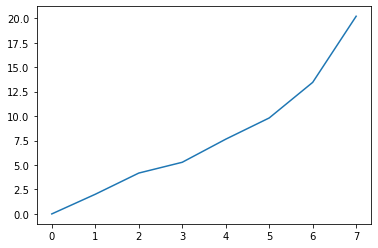

In [43]:
plt.plot(tt)
plt.show()

In [22]:
np.__version__

'1.19.0'

In [ ]:
e.shape

In [ ]:
simulator.graph.debug_dict

In [ ]:
simulator.graph.debug_show

In [ ]:
simulator.neuron_element.Utill.RDF_function

In [ ]:
with Timer("one_step_CPU") :
    for i in range(1) :
        simulator.one_step()

In [65]:
simulator.graph.hierarchical_graph['neuron_element'].node_dict['Inner/G0/c#0/@Input~Local~Spike']

{'label': 'Inner/G0/c#0/@Input~Local~Spike',
 'locality': 'Local',
 'role': '@Input',
 'group': 'Else',
 'bound_max': 1,
 'bound_min': 0,
 'Random': 0,
 'initial': 0.1,
 'original_label': 'Spike',
 'location': [[-314.9583435058594, -769.5],
  [0, 0],
  [-365.9583435058594, -967.5],
  [-915.7394685058595, -544.2037499999999]],
 'value': {'v': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. ]),
  'dv': array([0., 0., 0., 0., 0., 0., 0., 0.]),
  'ndv': array([0., 0., 0., 0., 0., 0., 0., 0.])},
 'synaps_num': -2,
 'queue': array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0.1, 0.1, 

In [66]:
simulator.graph.hierarchical_graph['neuron_model'].node_dict['Inner/G0/c#0']

{'label': 'Inner/G0/c#0',
 'neuron': 'LIF',
 'role': '@Input@Output',
 'locality': 'Local',
 'original_label': 'c#0',
 'location': [[-314.9583435058594, -769.5],
  [0, 0],
  [-365.9583435058594, -967.5]],
 'local_synaps': array(['Inner/G0/b#0 -> Inner/G0/c#0 S0',
        'Inner/G0/c#0 -> Inner/G0/c#0 S1',
        'Inner/G0/a#0 -> Inner/G0/c#0 S2',
        'Inner/G0/b#0 -> Inner/G0/c#0 S3',
        'Inner/G0/b#0 -> Inner/G0/c#0 S4',
        'Inner/G0/a#0 -> Inner/G0/c#0 S5',
        'Inner/G0/c#0 -> Inner/G0/c#0 S6',
        'Inner/G0/a#0 -> Inner/G0/c#0 S7'], dtype='<U32'),
 'local_synaps_index': 8,
 'local_synaps_num': 8,
 'global_synaps': array([], dtype=float64),
 'global_synaps_index': 0,
 'global_synaps_num': 0,
 'depth': 2,
 'hierarchy_name': 'neuron_model'}

In [ ]:
len(simulator.graph.hierarchical_graph["neuron_model"].node_dict)

In [ ]:
import numpy as np
a = [[1,2,3],[1,2,3]]
b = np.array(a)

In [ ]:
b.shape

In [ ]:
c = b[0]

In [ ]:
c = c+np.array([1,1,1])

In [ ]:
b[0] = np.array([4,5,6])

In [ ]:
b

In [ ]:
import json
json.dump(b)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
simulator.graph.debug_visualization(50, "Inner/G0/c#0/NMDAR")

In [ ]:
simulator.graph.hierarchical_up_group_dict

In [ ]:
for neuron_model_label in simulator.graph.hierarchical_graph["neuron_model"].node_dict:
    neuron_model = simulator.graph.node_label_dict[neuron_model_label]
    print(neuron_model["label"] +"\t\t"+ str(neuron_model["local_synaps_num"])) 

In [ ]:
for neuron_element_label in simulator.graph.hierarchical_graph["neuron_element"].node_dict:
    neuron_element = simulator.graph.node_label_dict[neuron_element_label]
    print(neuron_element["label"] +"\t\t"+ str(neuron_element["synaps_num"])) 

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].edge_dict

In [ ]:
simulator.graph.hierarchical_graph["neuron_model"].node_dict["Inner/G0/a#0"]

In [ ]:
simulator.graph.hierarchical_graph["neuron_model"].node_dict["LIF Trainer/G0/a#0"]

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].node_dict["LIF Trainer/G0/a#0/@Input~Global~Spike"]

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].node_dict["LIF Trainer/G0/a#0/Inner"]

In [ ]:
simulator.graph.job_list

In [ ]:
import numpy as np
a = np.array([[0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
         0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. ]])

np.array([sum(a[:,6])])

In [ ]:
simulator.graph.hierarchical_graph["neuron_model"].node_dict["LIF Trainer/G0/a#0"]

In [ ]:
simulator.graph.global_input_job_list

In [ ]:
a

In [ ]:
simulator.graph.debug_by_networkx()

In [ ]:
simulator.graph.hierarchical_graph["neuron_element"].node_from_dict

In [ ]:
import random
random.randint(2,5)

In [ ]:
import numpy as np
a = np.array([[1,2],[3,4]])

In [ ]:
b = np.array([[1,2],[3,4]])

In [ ]:
np.zeros(a.shape)

In [ ]:
a = np.array([1,2])

In [ ]:
a = np.array([a])

In [ ]:
a

In [ ]:
b*a

In [ ]:
np.dot(a,b)

In [ ]:
c = np.delete(a,[2,3],0)

In [ ]:
log(a)

In [ ]:
c

In [ ]:
import numpy as np
a ={1: np.array([1,2,3,4])}
b = {1: np.array([10])}
c ={1: np.array([1,2,3,4])}

In [ ]:
d=a.get(1)

In [ ]:
a[1] = b[1]

In [ ]:
d

In [ ]:
b[1] = np.array([20])

In [ ]:
a =np.array([1,2,3,4,25])
b =np.array([15])
c = a&b

In [ ]:
c

In [ ]:
b

In [ ]:
for v, id in enumerate(a):
    print(v)
    print(id)

In [ ]:
import numpy as np

In [ ]:
a = {1:{1:1}}
b=a[1]
b[1]=2
a

In [ ]:
len(a)

In [ ]:
import pycuda.driver as cuda

In [ ]:
a = np.array([])

In [ ]:
a = np.concatenate((a, np.array(['ㅁ'])))
print(a)

In [ ]:
np.where(a==0)[0]

In [ ]:
import time
a = {1:1}
b=0

#a={}


whole_time0 = 0
whole_time1 = 0
whole_time2 = 0

for i in range(1000000) :
    
    start1 = time.time()
    
    for k in a :
        b=b+a[k]
        break
    
    
    end1 = time.time()
    whole_time1 = whole_time1+end1 - start1
    
    
    start2 = time.time()
    
    if len(a)==1 :
        b=b+list(a.values())[0]
    
    
    end2 = time.time()
    whole_time2 = whole_time2+end2 - start2
    
    start0 = time.time()
    end0 = time.time()
    whole_time0 = whole_time0+end0 - start0

print(whole_time1 - whole_time0)
print(whole_time2 - whole_time0)

In [ ]:
neuron_network.graph.hierarchical_graph["neuron_model"].node_dict

In [ ]:
a = {1:'1',2:'2'}
b=a
a[3]='3'
next(iter(a))

In [ ]:
a={}
next(iter(a))

In [ ]:
iter(a)

In [ ]:
a = {1:'1'}
next(iter(a))

In [ ]:
c = dict(a)
c.update(b)
c

In [ ]:
neuron_network.graph.hierarchical_graph["neuron_group"].node_dict

In [ ]:
from random import *
random()

In [ ]:
NeuralNetwork.graph.hierarchical_graph['neuron_model'].node_dict['Inner@1\\n0\\Na+ Channel']["neuron_model"].neuron_node

In [ ]:
import random
import time
import timeit
start = timeit.timeit() 

time.sleep(1)

a = random.random()


print(timeit.timeit() - start)

In [ ]:
import timeit




t1 = timeit.timeit(lambda: "-".join(map(str, range(100))), number=10000)
print(t1)


In [ ]:
NeuralNetwork.network_json

In [ ]:
NeuralNetwork.graph.node_label_dict

In [ ]:
NeuralNetwork.graph.hierarchical_group_dict

In [ ]:
NeuralNetwork.graph.hierarchical_graph['neuron'].edge_dict

In [ ]:
NeuralNetwork.makeInitNeuron()

In [ ]:
NeuralNetwork.neuron_graph.node_dict

In [ ]:
NeuralNetwork.network_json

In [ ]:
NeuralNetwork.neuron_group_dict['Inner@1'].neuron_dict[0].edges

In [ ]:
layer1 = {'nodes':[1,2,3], 'edges':[(1,2),(2,3)]}
layer2 = {'nodes':[1,2,3], 'edges':[(1,2),(1,2)]}
layer3 = {'nodes':[1,2], 'edges':[(1,2)]}
layer4 = {'nodes':[1,2,3,4], 'edges':[(1,2),(1,3),(1,4)]}

In [ ]:
from Graph import Graph

testGraph = Graph()

testNodeB = [1,2,3,4,5,6,7,8]
testEdgeB = [(2,1), (3,1),(4,1),(1,5),(1,6),(1,7), (4,7)]

testNodeA = []
for node in testNodeB :
    testNodeA.append({'label':node})
    
testEdgeA = []
id = 0
for edge in testEdgeB :
    testEdgeA.append({'from':edge[0], 'to':edge[1], 'label':id})
    id = id+1

In [ ]:
testNodeA

In [ ]:
testEdgeA

In [ ]:
testGraphA = {"nodes":testNodeA, "edges":testEdgeA}

In [ ]:
testGraph.initGraph(testGraphA)

In [ ]:
testGraph.deleteNode({'label':1})

In [ ]:
testGraph.node_dict

In [ ]:
testGraph.edge_dict

In [ ]:
testGraph.node_from_dict

In [ ]:
testGraph.node_to_dict

In [ ]:
import networkx as nx

In [ ]:
def R(x) :
    return 0
    #return x/2

def D(x) :
    return x/2

import numpy as np
dt = 1/100
T = 10

SL = int(T/dt)

a = np.sin(np.arange(0, T, dt))
da = np.full((SL,),dt, dtype=float)
b = np.full((SL,),0, dtype=float)
db = np.full((SL,),0, dtype=float)

for i in range (SL) :
    da[i] = a[i]-a[i-1]
    db[i] = R(a[i])*da[i] + D(a[i])*dt
    b[i] = b[i-1]+db[i]
    
ans = np.square(a)/4

In [ ]:
from matplotlib import pyplot as plt

plt.plot(a)
plt.plot(da)
plt.plot(b)
plt.plot(db)
plt.legend(['a','da','bd','db'])
plt.show()

plt.plot(a)
plt.plot(da)
plt.plot(ans)
plt.plot(db)
plt.legend(['a','da','ans','db'])
plt.show()

plt.plot(a)
plt.plot(da)
plt.plot(b)
plt.plot(ans)
plt.plot(db)
plt.legend(['a','da','b','ans','db'])
plt.show()